In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from scipy import signal
import librosa
import time
from scipy.io import wavfile

!wget https://ursinus-cs372-s2023.github.io/HW6_StringAlong/data.wav
!wget https://ursinus-cs372-s2023.github.io/HW6_StringAlong/marvin.wav
!wget https://ursinus-cs372-s2023.github.io/HW6_StringAlong/adele.wav

!pip install torchcrepe
import torchcrepe # https://github.com/maxrmorrison/torchcrepe

--2023-05-04 23:11:45--  https://ursinus-cs372-s2023.github.io/HW6_StringAlong/data.wav
Resolving ursinus-cs372-s2023.github.io (ursinus-cs372-s2023.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to ursinus-cs372-s2023.github.io (ursinus-cs372-s2023.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25135448 (24M) [audio/wav]
Saving to: ‘data.wav.1’

data.wav.1          100%[===================>]  23.97M  98.6MB/s    in 0.2s    

2023-05-04 23:11:46 (98.6 MB/s) - ‘data.wav.1’ saved [25135448/25135448]

--2023-05-04 23:11:46--  https://ursinus-cs372-s2023.github.io/HW6_StringAlong/marvin.wav
Resolving ursinus-cs372-s2023.github.io (ursinus-cs372-s2023.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to ursinus-cs372-s2023.github.io (ursinus-cs372-s2023.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328174 (320K) [audio/wa

# Utility Functions (Given)

General purpose functions that will help us with specific parts of the pipeline

In [ ]:
def upsample_time(X, hop_length, mode='nearest'):
    """
    Upsample a tensor by a factor of hop_length along the time axis
    
    Parameters
    ----------
    X: torch.tensor(M, T, N)
        A tensor in which the time axis is axis 1
    hop_length: int
        Upsample factor
    mode: string
        Mode of interpolation.  'nearest' by default to avoid artifacts
        where notes in the violin jump by large intervals
    
    Returns
    -------
    torch.tensor(M, T*hop_length, N)
        Upsampled tensor
    """
    X = X.permute(0, 2, 1)
    X = nn.functional.interpolate(X, size=hop_length*X.shape[-1], mode=mode)
    return X.permute(0, 2, 1)

def fftconvolve(x, h):
    """
    Perform a fast convolution of two tensors across their last axis
    by using the FFT. Since the DFT assumes circularity, zeropad them 
    appropriately before doing the FFT and slice them down afterwards
    
    The length of the result will be equivalent to np.convolve's 'same'
    
    Refer to this module for more background:
    https://ursinus-cs372-s2023.github.io/Modules/Module14/Video4
    
    Parameters
    ----------
    x: torch.tensor(..., N1)
        First tensor
    h: torch.tensor(..., N2)
        Second tensor
    
    Returns
    -------
    torch.tensor(..., max(N1, N2))
    Tensor resulting from the convolution of x and y across their last axis,
    """
    N = max(x.shape[-1], h.shape[-1])
    if x.shape[-1] != h.shape[-1]:
        # Zeropad so they're equal
        if x.shape[-1] < N:
            x = nn.functional.pad(x, (0, N-x.shape[-1]))
        if h.shape[-1] < N:
            h = nn.functional.pad(h, (0, N-h.shape[-1]))
    x = nn.functional.pad(x, (0, N))
    h = nn.functional.pad(h, (0, N))
    X = torch.fft.rfft(x)
    H = torch.fft.rfft(h)
    y = torch.fft.irfft(X*H)
    return y[..., 0:N]


def plot_stft_comparison(F, L, X, Y, reverb, losses=torch.tensor([]), win=1024, sr=16000):
    """
    Some code to help compare the STFTs of ground truth and output audio, while
    also plotting the frequency, loudness, and reverb to get an idea of what the 
    inputs to the network were that gave rise to these ouputs.  It's very helpful
    to call this method while monitoring the training of the network
    
    Parameters
    ----------
    F: torch.tensor(n_batches, n_samples/hop_length, 1)
         Tensor holding the pitch estimates for the clips
    L: torch.tensor(n_batches, n_samples/hop_length, 1)
         Tensor holding the loudness estimates for the clips
    X: torch.tensor(n_batches, n_samples, 1)
        Ground truth audio
    Y: torch.tensor(n_batches, n_samples, 1)
        Output audio from the network->decoder
    reverb: torch.tensor(reverb_len)
        The learned reverb
    losses: list
        A list of losses over epochs over time
    win: int
        Window length to use in the STFT
    sr: int
        Sample rate of audio (used to help make proper units for time and frequency)
    """
    hop = 256
    hann = torch.hann_window(win).to(X)
    SX = torch.abs(torch.stft(X.squeeze(), win, hop, win, hann, return_complex=True))
    SY = torch.abs(torch.stft(Y.squeeze(), win, hop, win, hann, return_complex=True))
    print(SX.shape)
    extent = (0, SX.shape[2]*hop/sr, SX.shape[1]*sr/win, 0)
    plt.subplot(321)
    plt.imshow(torch.log10(SX.detach().cpu()[0, :, :]), aspect='auto', cmap='magma', extent=extent)
    plt.title("Ground Truth")
    plt.ylim([0, 8000])
    plt.xlabel("Time (Sec)")
    plt.ylabel("Frequency (hz)")
    
    plt.subplot(322)
    plt.imshow(torch.log10(SY.detach().cpu()[0, :, :]), aspect='auto', cmap='magma', extent=extent)
    plt.title("Synthesized")
    plt.ylim([0, 8000])
    plt.xlabel("Time (Sec)")
    plt.ylabel("Frequency (hz)")
    
    plt.subplot(323)
    plt.plot(F.detach().cpu()[0, :, 0])
    plt.title("Fundamental Frequency")
    plt.xlabel("Window index")
    plt.ylabel("Hz")
    plt.subplot(324)
    plt.plot(L.detach().cpu()[0, :, 0])
    plt.title("Loudness")
    plt.xlabel("Window Index")
    plt.ylabel("Z-normalized dB")
    if torch.numel(losses) > 0:
        plt.subplot(325)
        plt.plot(losses.detach().cpu().numpy().flatten())
        plt.yscale("log")
        plt.title("Losses (Current {:.3f})".format(losses[-1]))
        plt.xlabel("Epoch")
    plt.subplot(326)
    plt.plot(reverb.detach().cpu().flatten())
    plt.title("Impulse Response")
    plt.xlabel("Sample index")

################################################
# Loudness code modified from original Google Magenta DDSP implementation in tensorflow
# https://github.com/magenta/ddsp/blob/86c7a35f4f2ecf2e9bb45ee7094732b1afcebecd/ddsp/spectral_ops.py#L253
# which, like this repository, is licensed under Apache2 by Google Magenta Group, 2020
# Modifications by Chris Tralie, 2023

def power_to_db(power, ref_db=0.0, range_db=80.0, use_tf=True):
    """Converts power from linear scale to decibels."""
    # Convert to decibels.
    db = 10.0*np.log10(np.maximum(power, 10**(-range_db/10)))
    # Set dynamic range.
    db -= ref_db
    db = np.maximum(db, -range_db)
    return db

def extract_loudness(x, sr, hop_length, n_fft=512):
    """
    Extract the loudness in dB by using an A-weighting of the power spectrum
    (section B.1 of the paper)

    Parameters
    ----------
    x: ndarray(N)
        Audio samples
    sr: int
        Sample rate (used to figure out frequencies for A-weighting)
    hop_length: int
        Hop length between loudness estimates
    n_fft: int
        Number of samples to use in each window
    """
    # Computed centered STFT
    S = librosa.stft(x, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, center=True)
    
    # Compute power spectrogram
    amplitude = np.abs(S)
    power = amplitude**2

    # Perceptual weighting.
    freqs = np.arange(S.shape[0])*sr/n_fft
    a_weighting = librosa.A_weighting(freqs)[:, None]

    # Perform weighting in linear scale, a_weighting given in decibels.
    weighting = 10**(a_weighting/10)
    power = power * weighting

    # Average over frequencies (weighted power per a bin).
    avg_power = np.mean(power, axis=0)
    loudness = power_to_db(avg_power)
    return np.array(loudness, dtype=np.float32)

################################################

# Part 1: Dataset

## FM Synthesis Dataset (Given)

For debugging, if you need it.  Your network should at least be able to learn these very simple sounds, so if it can't, you should figure out what the problem is before you move onto training your network on the real violin audio

In [ ]:
class FMDataset(Dataset):
    def __init__(self, sr, hop_length, samples_per_batch=1000):
        """
        Instantiate an fm dataset
        
        Parameters
        ----------
        sr: int
            Sample rate
        hop_length: int
            Samples between loudness and pitch frames
        samples_per_batch: int
            The length of this object
        """
        self.sr = sr
        self.hop_length = hop_length
        self.samples_per_batch = samples_per_batch
    
    def __len__(self):
        return self.samples_per_batch
    
    def __getitem__(self, idx):
        """
        Generate a random FM plucked string note between A3 and A5 
        over a duration of 4 seconds
        
        Parameters
        ----------
        idx: int
            Index of example (ignored because data is random)
        
        Returns
        -------
        x: ndarray(sr*4)
            Audio samples
        pitch: ndarray(sr*4//hop_length)
            The pitch (a constant line since this is one solid note)
        loudness: ndarray(sr*4//hop_length)
            Loudness
        """
        note = np.random.randint(-12, 12)
        sr = self.sr
        ratio = 1
        I = 8
        lam = 3
        duration = 4
        envelope = lambda N, sr, lam: np.exp(-lam*np.arange(N)/sr)
        N = int(duration*sr)
        ts = np.arange(N)/sr
        f = 440*2**(note/12)
        fm = f*ratio
        x = np.cos(2*np.pi*f*ts + envelope(N, sr, lam)*I*(np.cos(2*np.pi*fm*ts)))
        loudness = envelope(N, sr, lam)
        x = x*loudness
        K = x.size//self.hop_length
        loudness = np.array(loudness[0::self.hop_length], dtype=np.float32)
        loudness = 10*np.log10(loudness**2+1e-8)
        loudness = torch.from_numpy(loudness).view(K, 1)
        x = torch.from_numpy(x).view(x.size, 1)
        # Extract pitch and loudness
        pitch = 440*(2**(note/12))*torch.ones(K)
        pitch = pitch.view(K, 1)
        return x, pitch, loudness

In [ ]:
FM = FMDataset(sr=16000, hop_length=64)
#print(FM[5])

## Instrument Dataset 

In [ ]:
## TODO: Fill this in!

class InstrumentData(Dataset):
  def __init__(self, x, sr, hop_length, samples_per_batch=5000):
    self.x = x
    self.sr = sr
    self.hop_length = hop_length
    self.samples_per_batch = samples_per_batch
    self.loudness = extract_loudness(self.x, self.sr, self.hop_length, n_fft=512)
    self.mean = np.mean(self.loudness) ## gets the mean of loudness
    self.std = np.std(self.loudness)  ## gets the standard deviation of loudness
    self.loudness = (self.loudness - self.mean) / self.std   ## normalized loudness = (loudness - mean) / standard deviation
    self.pitch = torchcrepe.predict(torch.from_numpy(x).view((1, x.size)),sr,hop_length,50,2000,'full',batch_size=2048,device='cuda').flatten()
    pitch_shape = self.pitch.shape[0]
    loudness_shape = self.loudness.shape[0]
    if(pitch_shape != loudness_shape):
      ## Crop the pitch and loudness arrays down to have the minimum number of samples between the two
      samples = min(pitch_shape, loudness_shape)  ## minimum number of samples between the two
      self.pitch[:samples]
      self.loudness[:samples]
    else:
      samples = pitch_shape
    ## crop the audio down so that it has this number of samples times the hop_length
    self.x[:min(samples*self.hop_length, self.x.shape[0])]


  def __len__(self):
    return self.samples_per_batch


  def __getitem__(self, idx):
    """
    Generate a random 4-second clip from x along with the coorsponding ones from pitch and loudness
    
    Parameters
    ----------
    idx: int
        Index of example (ignored because data is random)
    
    Returns
    -------
    x: ndarray(sr*4)
        Audio samples
    pitch: ndarray(sr*4//hop_length)
        The pitch (a constant line since this is one solid note)
    loudness: ndarray(sr*4//hop_length)
        Loudness
    """
    duration = 4
    
    N = int(duration*sr) ## N being 4 seconds long
    x = self.x
    x_idx = np.random.randint(0, x.shape[0] - N)
    x = x[x_idx:x_idx+N]
    #print(x.shape)
    x = torch.from_numpy(x).view(x.size, 1) # converts to a column

    N = 400
    pitch = self.pitch
    pitch_idx = x_idx//self.hop_length   ## divide by ?? to get corresponding starting pitch array index
    pitch = pitch[pitch_idx: pitch_idx+N]
    pitch = pitch.view(torch.numel(pitch), 1)

    loudness = self.loudness
    loudness_idx = x_idx//self.hop_length   ## divide by ?? to get corresponding starting loudness array index
    loudness = loudness[loudness_idx: loudness_idx+N]
    loudness = torch.from_numpy(loudness).view(loudness.size, 1)

    return x, pitch, loudness


In [ ]:
x, sr = librosa.load("data.wav", sr=16000)
ID = InstrumentData(x,sr,64)

/usr/local/lib/python3.10/dist-packages/librosa/core/convert.py:1332: RuntimeWarning: divide by zero encountered in log10
  + 2 * np.log10(f_sq)


Testing shapes

In [ ]:
print(ID.loudness.shape[0], ID.pitch.shape[0])
print(196371 * 64)
print(ID.x.shape)
x, pitch, loudness = ID[0]
print(x.view(torch.numel(x), 1).shape, pitch.shape, loudness.shape) ## 64,000 400 400

196371 196371
12567744
(12567702,)
torch.Size([64000, 1]) torch.Size([400, 1]) torch.Size([400, 1])


Test for Part 1

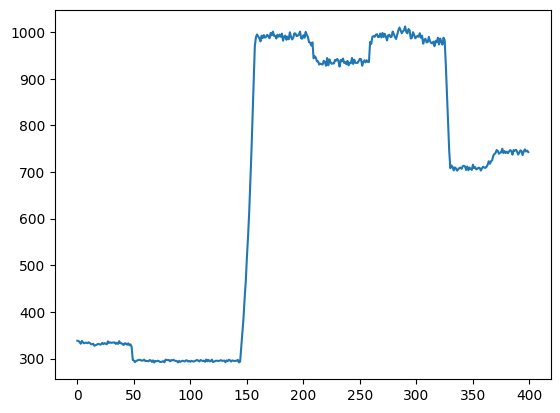

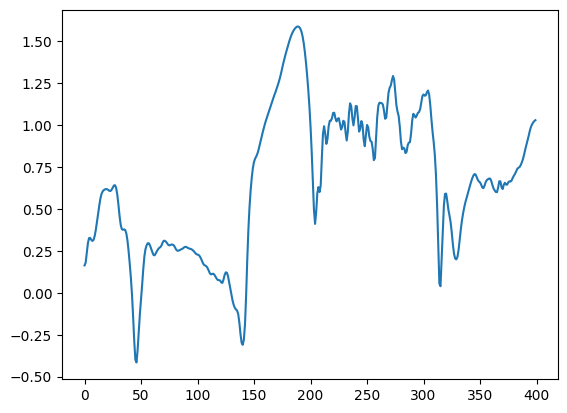

In [ ]:
x, f, l = ID[0]

#plt.plot(x)
plt.figure()
plt.plot(f)
plt.figure()
plt.plot(l)
#plt.legend(["Pitch", "Loudness"])
ipd.Audio(x.T, rate = 16000)

# Part 2a: Decoder Architecture

Section B.2 of the paper


In [ ]:
def modified_sigmoid(x):
    return 2*torch.sigmoid(x)**np.log(10) + 1e-7

## TODO: Fill this in!

In [ ]:
class MLP(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.input_size = input_size
    self.output_size = output_size
    
    self.model = nn.Sequential(
        nn.Linear(in_features=self.input_size, out_features=self.output_size),
        nn.LayerNorm(self.output_size),
        nn.LeakyReLU(),
        nn.Linear(in_features=self.output_size, out_features=self.output_size),
        nn.LayerNorm(self.output_size),
        nn.LeakyReLU(),
        nn.Linear(in_features=self.output_size, out_features=self.output_size),
        nn.LayerNorm(self.output_size),
        nn.LeakyReLU()
      )
    self.model = self.model.to('cuda')
    #self.model(x)
    
  def forward(self, x):
    return self.model(x)

In [ ]:
class DDSPDecoder(nn.Module):
  def __init__(self, n_units, sr, n_harmonics, n_bands, reverb_len):
    super().__init__()
    self.n_units = n_units
    self.sr = sr
    self.n_harmonics = n_harmonics
    self.n_bands = n_bands
    self.reverb_len = reverb_len
    # layer 1 - pitch
    self.MLP_pitch = MLP(input_size=1, output_size=self.n_units)
    self.MLP_pitch = self.MLP_pitch.to('cuda')
    # layer 1 - loudness
    self.MLP_loudness = MLP(input_size=1, output_size=self.n_units)
    self.MLP_loudness = self.MLP_loudness.to('cuda')
    # layer 2 - GRU
    self.GRU = nn.GRU(input_size=(self.n_units*2), hidden_size=self.n_units, batch_first=True)
    self.GRU = self.GRU.to('cuda')
    # layer 3 - MLP_gru
    self.MLP_GRU = MLP(input_size=(3*self.n_units), output_size=self.n_units)
    self.MLP_GRU = self.MLP_GRU.to('cuda')
    # layer linear harmonics
    self.linear_harmonics = nn.Linear(in_features=self.n_units, out_features=self.n_harmonics)
    self.linear_harmonics = self.linear_harmonics.to('cuda')
    # layer linear amplitude
    self.linear_amplitude = nn.Linear(in_features=self.n_units, out_features=1)
    self.linear_amplitude = self.linear_amplitude.to('cuda')
    # layer linear subtractive
    self.linear_subtractive = nn.Linear(in_features=self.n_units, out_features=self.n_bands)
    self.linear_subtractive = self.linear_subtractive.to('cuda')
    # parameter reverb
    self.reverb = nn.Parameter(torch.rand(reverb_len)*1e-4-0.5e-4)
    #self.reverb = self.reverb.to('cuda')
  
  def get_num_parameters(self):
    total = 0
    for p in self.parameters():
        total += np.prod(p.shape)
    return total

  def forward(self, F, L):
    F = self.MLP_pitch(F)
    L = self.MLP_loudness(L)
    
    joined = torch.cat((F, L), dim=2)
    gru_tensor, _ = self.GRU(joined)
    #print(F.shape, L.shape, gru_tensor.shape)
    joined_GRU = torch.cat((F,L,gru_tensor), dim=2)
    gru_tensor = self.MLP_GRU(joined_GRU)
    C = self.linear_harmonics(gru_tensor)
    A = self.linear_amplitude(gru_tensor)
    S = self.linear_subtractive(gru_tensor)
    # Based on the input frequency, zero out the elements in the harmonics tensor C 
    # that are above the Nyquist rate (sr/2) to avoid aliasing during training
    C[C>(self.sr/2)] = 0
    C = C/(1e-8+torch.sum(C, dim=2, keepdims=True))
    C = modified_sigmoid(C)
    A = modified_sigmoid(A)
    S = modified_sigmoid(S)
    transformed_reverb = torch.tanh(self.reverb)
    return A, C, S, transformed_reverb




In [ ]:
device = 'cuda'
layer = MLP(input_size=1, output_size=512)
layer = layer.to(device)
x = x.to(device)
x_mlp = layer.forward(x)
print(x.shape[0])
print(x_mlp.shape[0])


64000
64000


In [ ]:
decoder = DDSPDecoder(n_units=512, sr=sr, n_harmonics=100, n_bands=65, reverb_len=sr)
print(decoder.get_num_parameters())

4837670


In [ ]:
loader = DataLoader(ID, batch_size=16, shuffle=True)
X, F, L = next(iter(loader))
print("X.shape", X.shape)
print("F.shape", F.shape)
print("L.shape", L.shape)

X.shape torch.Size([16, 64000, 1])
F.shape torch.Size([16, 400, 1])
L.shape torch.Size([16, 400, 1])


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
decoder = decoder.to(device)
A, C, S, reverb = decoder(F.to(device), L.to(device))
print("A.shape", A.shape)
print("C.shape", C.shape)
print("S.shape", S.shape)
print("reverb.shape", reverb.shape)

A.shape torch.Size([16, 400, 1])
C.shape torch.Size([16, 400, 100])
S.shape torch.Size([16, 400, 65])
reverb.shape torch.Size([16000])


# Part 2b: Synthesizer
Section 3.2, 3.3 B.5

Use the outputs of the decoder network to create audio samples, *using only torch methods*


## Subtractive Synthesizer (Given)

In [ ]:
def subtractive_synthesis(S, hop_length):
    """
    Perform subtractive synthesis by converting frequency domain transfer
    functions into causal, zero-phase, windowed impulse responses
    
    Parameters
    ----------
    S: n_batches x time x n_bands
        Subtractive synthesis parameters
    hop_length: int
        Hop length between subtractive synthesis windows
        
    Returns
    -------
    torch.tensor(n_batches, time*hop_length, 1)
        Subtractive synthesis audio components for each clip
    """
    
    # Put an imaginary component of all 0s across a new last axis
    # https://pytorch.org/docs/stable/generated/torch.view_as_complex.html
    S = torch.stack([S, torch.zeros_like(S)], -1)
    S = torch.view_as_complex(S)
    # Do the inverse real DFT (assuming symmetry)
    h = torch.fft.irfft(S)
    
    # Shift the impulse response to zero-phase
    nh = h.shape[-1]
    h = torch.roll(h, nh//2, -1)
    # Apply hann window
    h = h*torch.hann_window(nh, dtype=h.dtype, device=h.device)
    # Shift back to causal
    h = nn.functional.pad(h, (0, hop_length-nh))
    h = torch.roll(h, -nh//2, -1)
    
    # Apply the impulse response to random noise in [-1, 1]
    noise = torch.rand(h.shape[0],h.shape[1],hop_length).to(h.device)
    noise = noise*2 - 1
    noise = fftconvolve(noise, h).contiguous()
    
    # Flatten nonoverlapping samples to one contiguous stream
    return noise.reshape(noise.shape[0], noise.shape[1]*noise.shape[2], 1)

## Additive Synthesizer / Putting It Together

In [ ]:
## TODO: Fill this in!
def synthesize(F, C, A, S, reverb):
  # start by upsampling C, A, F to audio sample rate
  hop_length = 64
  C = upsample_time(C, hop_length)
  A = upsample_time(A, hop_length)
  F = upsample_time(F, hop_length)
  # Use C, A, F to create a set of harmonics at the appropriate amplitudes
  Additive = C + A + F
  # permform subtractive synthesis by sending along S and hop_length
  Subtractive = subtractive_synthesis(S, hop_length)
  # sum together the additive and subtractive components
  summed = Subtractive + Additive
  Y = None
  summed = fftconvolve(summed, Y.squeeze())
  return summed


# Part 3: Loss Function

Implement Multi-Scale Spectral Loss (DDSP Section 4.2.1)

Use torch.stft to help you.  Don't forget to squeeze() the input to the STFT to get rid of the singleton dimension at the end


In [ ]:
## TODO: Fill this in!

# Part 4: Testing Example Code

In [ ]:
## TODO: Fill this in!

# Part 5: Train Loop

Put it all together!

In [ ]:
## TODO: Fill this in!

# Musical Statement

In [ ]:
## TODO: Fill this in!  Have fun!